In [66]:
import pandas as pd
import time
import plotly.graph_objects as go
!pip install pyswarms
!pip install pyswarm
from pyswarm import pso
import networkx as nx
import pyswarms as ps
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import json

In [4]:
start_time_dijkstra = time.time()
df = pd.read_csv('/content/data_file.csv', header=None)

In [5]:
df.head()

,0,1,2
0,1,0.000000,8.157657
1,2,1400.124877,6.107682
2,3,3300.805188,4.148334
3,4,3701.634008,6.147944
4,5,4102.583249,6.088959


In [6]:
df.columns = ['Vehicle No.', 'x', 'y']

In [7]:
# Define base station coordinates
bs1_coordinates = (-1, -1)
bs2_coordinates = (56325, 9)

In [8]:
# Function to calculate Euclidean distance between two points
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

In [9]:
# Function to determine the closest base station for each vehicle
def assign_base_station(row):
    vehicle_coordinates = (row['x'], row['y'])

    distance_to_bs1 = calculate_distance(vehicle_coordinates, bs1_coordinates)
    distance_to_bs2 = calculate_distance(vehicle_coordinates, bs2_coordinates)

    if distance_to_bs1 < distance_to_bs2:
        return 1
    else:
        return 2

In [10]:
# Apply the function to each row in the DataFrame
df['base_station'] = df.apply(assign_base_station, axis=1)

In [11]:
df_split = df[['Vehicle No.', 'x', 'y', 'base_station']]

In [12]:
df_split.head()

,Vehicle No.,x,y,base_station
0,1,0.000000,8.157657,1
1,2,1400.124877,6.107682,1
2,3,3300.805188,4.148334,1
3,4,3701.634008,6.147944,1
4,5,4102.583249,6.088959,1


In [13]:
import matplotlib.pyplot as plt

In [14]:
"""colors = {1 : 'red', 2: 'blue'}
plt.scatter(df_split['x'], df_split['y'], c=[colors[base_station] for base_station in df_split['base_station']],
            label=df_split['base_station'])"""

"colors = {1 : 'red', 2: 'blue'}\nplt.scatter(df_split['x'], df_split['y'], c=[colors[base_station] for base_station in df_split['base_station']],\n            label=df_split['base_station'])"

In [15]:
def calculate_transmission_rate(d):
    if d >= 6000:
        return 0
    elif 4000 <= d < 6000:
        return 1
    elif 3000 <= d < 4000:
        return 2
    elif 2000 <= d < 3000:
        return 4
    elif 1000 <= d < 2000:
        return 6
    elif 500 <= d < 1000:
        return 8
    else:
        return 10

In [16]:
def initialize_graph(df_bs):
    G = nx.DiGraph()

    # Iterate through rows of df_bs to add nodes and edges
    for index, row in df_bs.iterrows():
        # Add base station node with coordinates
        bs_node = 'bs1' if row['base_station'] == 1 else 'bs2'
        G.add_node(bs_node, coordinates=bs1_coordinates if bs_node == 'bs1' else bs2_coordinates)

        # Add nodes for each vehicle with coordinates and transmission rate attribute
        vehicle_node = int(row['Vehicle No.'])
        G.add_node(vehicle_node, coordinates=(row['x'], row['y']))
        distance_bs = calculate_distance((row['x'], row['y']), bs1_coordinates if bs_node == 'bs1' else bs2_coordinates)
        transmission_rate_bs = calculate_transmission_rate(distance_bs)
        G.nodes[vehicle_node]['transmission_rate_to_bs'] = transmission_rate_bs

        # Add directed edge from vehicle to corresponding base station with weight, only if weight is not 0
        if transmission_rate_bs != 0:
            G.add_edge(vehicle_node, bs_node, weight=transmission_rate_bs)

    # Calculate transmission rates between vehicles
    for i, row1 in df_bs.iterrows():
        for j, row2 in df_bs.iterrows():
            if i != j:
                distance_ij = calculate_distance((row1['x'], row1['y']), (row2['x'], row2['y']))
                transmission_rate_ij = calculate_transmission_rate(distance_ij)

                # Add directed edge from i to j with weight, only if weight is not 0
                if transmission_rate_ij != 0:
                    G.add_edge(int(row1['Vehicle No.']), int(row2['Vehicle No.']), weight=transmission_rate_ij)

    return G

['bs1', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 'bs2', 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


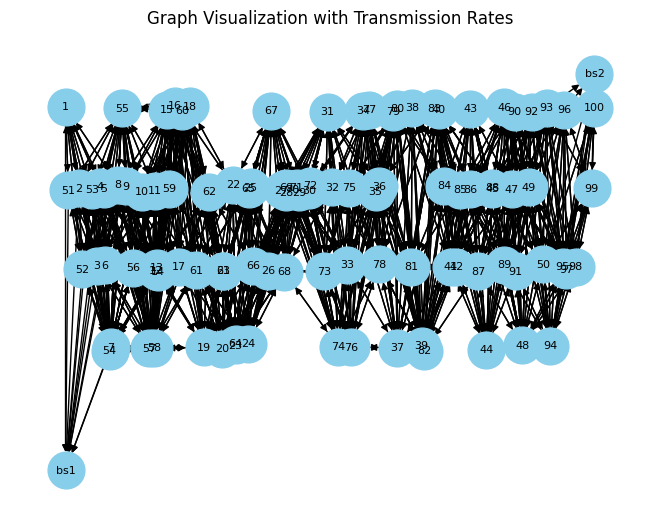

In [17]:
graph = initialize_graph(df_split)

print(graph.nodes)

# Extract node positions and labels
pos = nx.get_node_attributes(graph, 'coordinates')
labels = {node: node for node in graph.nodes}

# Manually set position for 'bs' if it's present in the graph
if 'bs1' in graph.nodes:
    bs_coordinates = bs1_coordinates
else:
    bs_coordinates = bs2_coordinates

# Directly retrieve transmission rates from node attributes
transmission_rates = {node: graph.nodes[node].get('transmission_rate_to_bs', 0) for node in graph.nodes}


# Draw the graph with nodes labeled
nx.draw(graph, pos, with_labels=False, node_size=700, node_color='skyblue', font_size=8)
nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8, font_color='black')

# Draw edge labels (transmission rates)
for edge in graph.edges:
    node1, node2 = edge
    label_pos = ((pos[node1][0] + pos[node2][0]) / 2, (pos[node1][1] + pos[node2][1]) / 2)
#     plt.text(label_pos[0], label_pos[1], f'TR: {transmission_rates[node1]}', color='red', fontsize=8, ha='center')

plt.title("Graph Visualization with Transmission Rates")
plt.show()

In [18]:
# Segregate cars based on their nearest base station
bs1_cars = df[df['base_station'] == 1]
bs2_cars = df[df['base_station'] == 2]

# Create a list of trace objects for points (cars) for each base station
trace_bs1_cars = go.Scatter3d(
    x=bs1_cars['x'],
    y=bs1_cars['y'],
    z=[0] * len(bs1_cars),
    mode='markers+text',
    marker=dict(size=5, color='blue'),
    text=[f' {car}' for car in bs1_cars['Vehicle No.']],
    textposition='top center',
    name='Cars near BS1'
)

trace_bs2_cars = go.Scatter3d(
    x=bs2_cars['x'],
    y=bs2_cars['y'],
    z=[0] * len(bs2_cars),
    mode='markers+text',
    marker=dict(size=5, color='green'),
    text=[f' {car}' for car in bs2_cars['Vehicle No.']],
    textposition='top center',
    name='Cars near BS2'
)

# Create trace objects for base stations
trace_bs1 = go.Scatter3d(
    x=[bs1_coordinates[0]],
    y=[bs1_coordinates[1]],
    z=[0],
    mode='markers+text',
    marker=dict(size=7, color='red'),
    text=['Base Station 1'],
    textposition='top center',
    name='Base Station 1'
)

trace_bs2 = go.Scatter3d(
    x=[bs2_coordinates[0]],
    y=[bs2_coordinates[1]],
    z=[0],
    mode='markers+text',
    marker=dict(size=7, color='orange'),
    text=['Base Station 2'],
    textposition='top center',
    name='Base Station 2'
)

fig = go.Figure(data=[trace_bs1_cars, trace_bs2_cars, trace_bs1, trace_bs2])

# Update layout for better visibility and hover information
fig.update_layout(
    title='3D Visualization of Cars with Nearest Base Stations',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    hovermode='closest'
)

fig.show()


In [19]:

# Create a 2D scatter plot
fig = go.Figure()

# Extract node positions in 2D space
x_nodes = [pos[node][0] for node in graph.nodes]
y_nodes = [pos[node][1] for node in graph.nodes]



# Adjust node size and edge thickness
node_size = 10
edge_thickness = 1

# Add nodes to the Plotly figure
for node, x, y in zip(graph.nodes, x_nodes, y_nodes):
    color = 'red' if node == 'bs1' else 'blue'
    fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers', marker=dict(size=node_size, color=color), text=[str(node)], name=str(node)))

# Add edges to the Plotly figure
for edge in graph.edges:
    node1, node2 = edge
    x_edge = [pos[node1][0], pos[node2][0]]
    y_edge = [pos[node1][1], pos[node2][1]]
    fig.add_trace(go.Scatter(x=x_edge, y=y_edge, mode='lines', line=dict(color='black', width=edge_thickness), hoverinfo='none'))

# Set layout
fig.update_layout(showlegend=False)  # Disable legend for clarity

# Show the Plotly figure
fig.show()





In [20]:
def get_coordinates(vehicle_number):
    for index, row in df_split.iterrows():
        if row['Vehicle No.'] == int(vehicle_number):
            coordinates = (row['x'], row['y'])
            return coordinates
    return None

In [21]:
def find_shortest_path(G, start_node, target_node):
    try:
        path = nx.shortest_path(G, source=start_node, target=target_node, weight='weight')
        return path
    except nx.NetworkXNoPath:
        return None

In [22]:
dijkstra_algorithm_solution = []

for index, row in df_split.iterrows():
    start_node = int(row['Vehicle No.'])
    target_node = 'bs1' if row['base_station'] == 1 else 'bs2'
    shortest_path_dijks = find_shortest_path(graph, start_node, target_node)

    transmission_rates = []
    routing_path = []

    # Calculate end-to-end transmission rate for the best solution
    for i in range(len(shortest_path_dijks) - 1):
        source_vehicle = shortest_path_dijks[i]
        target_vehicle = shortest_path_dijks[i + 1]

        if target_vehicle == 'bs1' or target_vehicle == 'bs2':
            target_coordinates = bs1_coordinates if target_vehicle == 'bs1' else bs2_coordinates
        else:
            target_coordinates = get_coordinates(target_vehicle)

        # Get the source vehicle's coordinates
        source_coordinates = get_coordinates(source_vehicle)

        # Calculate distance between source and target
        distance = calculate_distance(source_coordinates, target_coordinates)

        # Calculate transmission rate for the link
        transmission_rate = calculate_transmission_rate(distance)

        # Append information to the routing path
        routing_path.append((f"car -> {target_vehicle}", f"{transmission_rate} Mbps"))
        transmission_rates.append(transmission_rate)

    # Calculate end-to-end data transmission rate as the minimum of collected rates
    end_to_end_data_rate = min(transmission_rates)
    solution = {
        "Source node": shortest_path_dijks[0],
        "Routing path": routing_path,
        "End-to-end transmission rate": f"{end_to_end_data_rate} Mbps"
    }
    dijkstra_algorithm_solution.append(solution)

print(dijkstra_algorithm_solution)
end_time_dijkstra = time.time()
execution_time_dijkstra = end_time_dijkstra - start_time_dijkstra
print(f"Execution time for Dijkstra's algorithm: {execution_time_dijkstra} seconds")

[{'Source node': 1, 'Routing path': [('car -> 5', '1 Mbps'), ('car -> bs1', '1 Mbps')], 'End-to-end transmission rate': '1 Mbps'}, {'Source node': 2, 'Routing path': [('car -> 8', '1 Mbps'), ('car -> bs1', '1 Mbps')], 'End-to-end transmission rate': '1 Mbps'}, {'Source node': 3, 'Routing path': [('car -> bs1', '2 Mbps')], 'End-to-end transmission rate': '2 Mbps'}, {'Source node': 4, 'Routing path': [('car -> bs1', '2 Mbps')], 'End-to-end transmission rate': '2 Mbps'}, {'Source node': 5, 'Routing path': [('car -> bs1', '1 Mbps')], 'End-to-end transmission rate': '1 Mbps'}, {'Source node': 6, 'Routing path': [('car -> bs1', '1 Mbps')], 'End-to-end transmission rate': '1 Mbps'}, {'Source node': 7, 'Routing path': [('car -> bs1', '1 Mbps')], 'End-to-end transmission rate': '1 Mbps'}, {'Source node': 8, 'Routing path': [('car -> bs1', '1 Mbps')], 'End-to-end transmission rate': '1 Mbps'}, {'Source node': 9, 'Routing path': [('car -> 2', '1 Mbps'), ('car -> 8', '1 Mbps'), ('car -> bs1', '1 M

In [67]:
'''def run_dijkstra_algorithm_for_vehicle(df_split, graph, bs1_coordinates, bs2_coordinates, vehicle_row):
    start_node = int(vehicle_row['Vehicle No.'])
    target_node = 'bs1' if vehicle_row['base_station'] == 1 else 'bs2'
    shortest_path_dijks = find_shortest_path(graph, start_node, target_node)



    transmission_rates = []
    routing_path = []

    # Calculate end-to-end transmission rate for the best solution
    for i in range(len(shortest_path_dijks) - 1):
        source_vehicle = shortest_path_dijks[i]
        target_vehicle = shortest_path_dijks[i + 1]

        if target_vehicle == 'bs1' or target_vehicle == 'bs2':
            target_coordinates = bs1_coordinates if target_vehicle == 'bs1' else bs2_coordinates
        else:
            target_coordinates = get_coordinates(target_vehicle)

        # Get the source vehicle's coordinates
        source_coordinates = get_coordinates(source_vehicle)

        # Calculate distance between source and target
        distance = calculate_distance(source_coordinates, target_coordinates)

        # Calculate transmission rate for the link
        transmission_rate = calculate_transmission_rate(distance)

        # Append information to the routing path
        routing_path.append((f"car -> {target_vehicle}", f"{transmission_rate} Mbps"))
        transmission_rates.append(transmission_rate)

    # Calculate end-to-end data transmission rate as the minimum of collected rates
    end_to_end_data_rate = min(transmission_rates)
    solution = {
        "Source node": shortest_path_dijks[0],
        "Routing path": routing_path,
        "End-to-end transmission rate": f"{end_to_end_data_rate} Mbps"
    }

    return solution

# Usage:
dijkstra_algorithm_solution = []

for index, row in df_split.iterrows():
    solution = run_dijkstra_algorithm_for_vehicle(df_split, graph, bs1_coordinates, bs2_coordinates, row)
    dijkstra_algorithm_solution.append(solution)
print(dijkstra_algorithm_solution)
run_dijkstra_algorithm_for_vehicle(df_split, graph, bs1_coordinates, bs2_coordinates,vehicle_row)'''

'def run_dijkstra_algorithm_for_vehicle(df_split, graph, bs1_coordinates, bs2_coordinates, vehicle_row):\n    start_node = int(vehicle_row[\'Vehicle No.\'])\n    target_node = \'bs1\' if vehicle_row[\'base_station\'] == 1 else \'bs2\'\n    shortest_path_dijks = find_shortest_path(graph, start_node, target_node)\n    \n\n\n    transmission_rates = []\n    routing_path = []\n\n    # Calculate end-to-end transmission rate for the best solution\n    for i in range(len(shortest_path_dijks) - 1):\n        source_vehicle = shortest_path_dijks[i]\n        target_vehicle = shortest_path_dijks[i + 1]\n\n        if target_vehicle == \'bs1\' or target_vehicle == \'bs2\':\n            target_coordinates = bs1_coordinates if target_vehicle == \'bs1\' else bs2_coordinates\n        else:\n            target_coordinates = get_coordinates(target_vehicle)\n\n        # Get the source vehicle\'s coordinates\n        source_coordinates = get_coordinates(source_vehicle)\n\n        # Calculate distance betwee

In [23]:
from prettytable import PrettyTable

def format_output(dijkstra_algorithm_solution):
    formatted_output = []

    for entry in dijkstra_algorithm_solution:
        formatted_entry = {
            'Source node': entry['Source node'],
            'Routing path': ', '.join([f'{path[0]} ({path[1]})' for path in entry['Routing path']]),
            'End-to-end transmission rate': entry['End-to-end transmission rate']
        }
        formatted_output.append(formatted_entry)

    return formatted_output

# Example usage:


formatted_data = format_output(dijkstra_algorithm_solution)

# Create a PrettyTable object
table = PrettyTable()
table.field_names = ['Source node', 'Routing path', 'End-to-end transmission rate']

# Add data to the table
for entry in formatted_data:
    table.add_row([entry['Source node'], entry['Routing path'], entry['End-to-end transmission rate']])

# Print the table
print(table)

+-------------+-------------------------------------------------------------------------------------------------------------------------+------------------------------+
| Source node |                                                       Routing path                                                      | End-to-end transmission rate |
+-------------+-------------------------------------------------------------------------------------------------------------------------+------------------------------+
|      1      |                                          car -> 5 (1 Mbps), car -> bs1 (1 Mbps)                                         |            1 Mbps            |
|      2      |                                          car -> 8 (1 Mbps), car -> bs1 (1 Mbps)                                         |            1 Mbps            |
|      3      |                                                   car -> bs1 (2 Mbps)                                                   |            2 Mbps

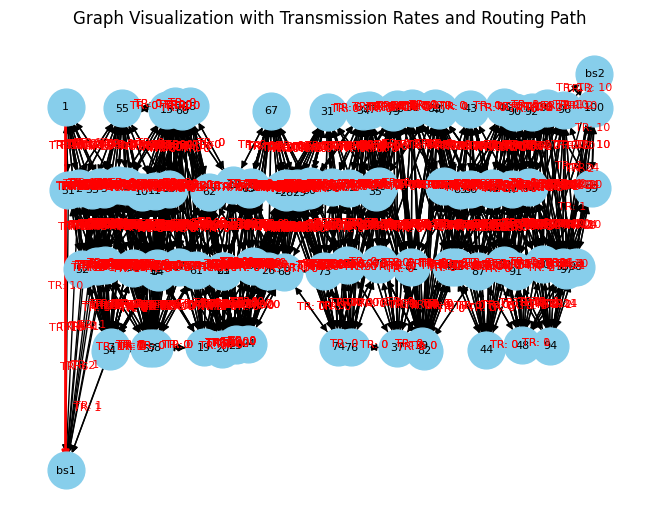

In [50]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to visualize the routing path on the graph
def visualize_routing_path(graph, routing_path):
    # Extract node positions and labels
    pos = nx.get_node_attributes(graph, 'coordinates')
    labels = {node: node for node in graph.nodes}

    # Manually set position for 'bs' if it's present in the graph
    if 'bs1' in graph.nodes:
        bs_coordinates = bs1_coordinates
    else:
        bs_coordinates = bs2_coordinates

    # Directly retrieve transmission rates from node attributes
    transmission_rates = {node: graph.nodes[node].get('transmission_rate_to_bs', 0) for node in graph.nodes}

    # Draw the graph with nodes labeled
    nx.draw(graph, pos, with_labels=False, node_size=700, node_color='skyblue', font_size=8)
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8, font_color='black')

    # Draw edge labels (transmission rates)
    for edge in graph.edges:
        node1, node2 = edge
        label_pos = ((pos[node1][0] + pos[node2][0]) / 2, (pos[node1][1] + pos[node2][1]) / 2)
        plt.text(label_pos[0], label_pos[1], f'TR: {transmission_rates[node1]}', color='red', fontsize=8, ha='center')

    # Highlight the routing path
    routing_path_edges = [(routing_path[i], routing_path[i + 1]) for i in range(len(routing_path) - 1)]
    nx.draw_networkx_edges(graph, pos, edgelist=routing_path_edges, edge_color='red', width=2)

    plt.title("Graph Visualization with Transmission Rates and Routing Path")
    plt.show()

# Example usage:
start_node_example = 1  # Replace with the actual starting node
target_node_example = 'bs1'  # Replace with the actual target node

# Find the shortest path using Dijkstra's algorithm
shortest_path_example = find_shortest_path(graph, start_node_example, target_node_example)

# Visualize the graph with the routing path highlighted
visualize_routing_path(graph, shortest_path_example)


In [55]:
import networkx as nx
from graphviz import Digraph

def generate_routing_path_dot(graph, routing_path):
    dot = Digraph(comment='Routing Path', format='png')
    dot.attr(layout='neato')  # Use 'neato' layout


    for node in graph.nodes:
        dot.node(str(node), label=str(node), style='filled', color='skyblue' if str(node).startswith('sensor') else 'orange' if str(node).startswith('bs') else 'gray')

    transmission_rates = {node: graph.nodes[node].get('transmission_rate_to_bs', 0) for node in graph.nodes}

    for edge in graph.edges:
        node1, node2 = edge
        dot.edge(str(node1), str(node2), label=f'TR: {transmission_rates[node1]}', color='black', fontcolor='red')

    # Highlight the routing path
    for i in range(len(routing_path) - 1):
        dot.edge(str(routing_path[i]), str(routing_path[i + 1]), color='red', penwidth='2')

    dot.render('routing_path_graph', format='svg', cleanup=True)


# Example usage:
# Assuming you already have the graph and shortest_path_example
generate_routing_path_dot(graph, shortest_path_example)


In [24]:
'''# Function to calculate the total weight of a path in the graph
def calculate_total_weight(G, path):
    total_weight = 0
    for i in range(len(path) - 1):
        total_weight += G[path[i]][path[i + 1]]['weight']
    return total_weight

# Objective function for PSO
def objective_function(weights, G, start_node, target_node):
    # Set new weights on the edges
    for i, edge in enumerate(G.edges):
        G[edge[0]][edge[1]]['weight'] = weights[i]

    # Find the shortest path
    shortest_path = find_shortest_path(G, start_node, target_node)

    # If a path is found, return its total weight as the objective value
    if shortest_path is not None:
        total_weight = calculate_total_weight(G, shortest_path)
        return total_weight
    else:
        # If no path is found, return a large value
        return float('inf')'''

"# Function to calculate the total weight of a path in the graph\ndef calculate_total_weight(G, path):\n    total_weight = 0\n    for i in range(len(path) - 1):\n        total_weight += G[path[i]][path[i + 1]]['weight']\n    return total_weight\n\n# Objective function for PSO\ndef objective_function(weights, G, start_node, target_node):\n    # Set new weights on the edges\n    for i, edge in enumerate(G.edges):\n        G[edge[0]][edge[1]]['weight'] = weights[i]\n\n    # Find the shortest path\n    shortest_path = find_shortest_path(G, start_node, target_node)\n\n    # If a path is found, return its total weight as the objective value\n    if shortest_path is not None:\n        total_weight = calculate_total_weight(G, shortest_path)\n        return total_weight\n    else:\n        # If no path is found, return a large value\n        return float('inf')"

In [25]:
'''G = graph

PSO_solution = []

for index, row in df_split.iterrows():
    # Get initial weights from the graph
    initial_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges]

    # Use PSO to optimize the weights
    lb = [0.1] * len(G.edges)  # Lower bounds for weights
    ub = [1.0] * len(G.edges)  # Upper bounds for weights

    start_node = int(row['Vehicle No.'])
    target_node = 'bs1' if row['base_station'] == 1 else 'bs2'
    shortest_path_pso = find_shortest_path(G, start_node, target_node)

    transmission_rates = []
    routing_path = []

    # Calculate end-to-end transmission rate for the best solution
    for i in range(len(shortest_path_pso) - 1):
        source_vehicle = shortest_path_pso[i]
        target_vehicle = shortest_path_pso[i + 1]

        if target_vehicle == 'bs1' or target_vehicle == 'bs2':
            target_coordinates = bs1_coordinates if target_vehicle == 'bs1' else bs2_coordinates
        else:
            target_coordinates = get_coordinates(target_vehicle)

        # Get the source vehicle's coordinates
        source_coordinates = get_coordinates(source_vehicle)

        # Calculate distance between source and target
        distance = calculate_distance(source_coordinates, target_coordinates)

        # Calculate transmission rate for the link
        transmission_rate = calculate_transmission_rate(distance)

        # Append information to the routing path
        routing_path.append((f"car -> {target_vehicle}", f"{transmission_rate} Mbps"))
        transmission_rates.append(transmission_rate)

    # Calculate end-to-end data transmission rate as the minimum of collected rates
    end_to_end_data_rate = min(transmission_rates)
    solution = {
        "Source node": shortest_path_pso[0],
        "Routing path": routing_path,
        "End-to-end transmission rate": f"{end_to_end_data_rate} Mbps"
    }

    PSO_solution.append(solution)

print(PSO_solution)
end_time_dijkstra = time.time()

# Calculate and print the execution time
execution_time_dijkstra = end_time_dijkstra - start_time_dijkstra
print(f"Execution time for Dijkstra's algorithm: {execution_time_dijkstra} seconds")'''

'G = graph\n\nPSO_solution = []\n\nfor index, row in df_split.iterrows():\n    # Get initial weights from the graph\n    initial_weights = [G[edge[0]][edge[1]][\'weight\'] for edge in G.edges]\n\n    # Use PSO to optimize the weights\n    lb = [0.1] * len(G.edges)  # Lower bounds for weights\n    ub = [1.0] * len(G.edges)  # Upper bounds for weights\n\n    start_node = int(row[\'Vehicle No.\'])\n    target_node = \'bs1\' if row[\'base_station\'] == 1 else \'bs2\'\n    shortest_path_pso = find_shortest_path(G, start_node, target_node)\n\n    transmission_rates = []\n    routing_path = []\n\n    # Calculate end-to-end transmission rate for the best solution\n    for i in range(len(shortest_path_pso) - 1):\n        source_vehicle = shortest_path_pso[i]\n        target_vehicle = shortest_path_pso[i + 1]\n\n        if target_vehicle == \'bs1\' or target_vehicle == \'bs2\':\n            target_coordinates = bs1_coordinates if target_vehicle == \'bs1\' else bs2_coordinates\n        else:\n   

In [29]:
#Function to calculate the total weight of a path in the graph
def calculate_total_weight(graph, path):
    total_weight = 0
    for i in range(len(path) - 1):
        total_weight += graph[path[i]][path[i + 1]]['weight']
    return total_weight

# Objective function for PSO
def objective_function(weights, graph, start_node, target_node):
    # Set new weights on the edges
    for i, edge in enumerate(graph.edges):
        graph[edge[0]][edge[1]]['weight'] = weights[i]

    # Find the shortest path
    shortest_path = find_shortest_path(graph, start_node, target_node)

    # If a path is found, return its total weight as the objective value
    if shortest_path is not None:
        total_weight = calculate_total_weight(graph, shortest_path)
        return total_weight
    else:
        # If no path is found, return a large value
        return float('inf')

# Function to find the shortest path in the graph using Dijkstra's algorithm

# Function to initialize the graph with weights
def initialize_graph_with_weights(df_bs):
    G = initialize_graph(df_bs)
    for i, row1 in df_bs.iterrows():
        for j, row2 in df_bs.iterrows():
            if i != j:
                distance_ij = calculate_distance((row1['x'], row1['y']), (row2['x'], row2['y']))
                transmission_rate_ij = calculate_transmission_rate(distance_ij)
                G.add_edge(int(row1['Vehicle No.']), int(row2['Vehicle No.']), weight=transmission_rate_ij)
    return G

# PSO optimization
def optimize_weights_pso(graph, start_node, target_node):
    # Get initial weights from the graph
    initial_weights = [graph[edge[0]][edge[1]]['weight'] for edge in graph.edges]

    # Use PSO to optimize the weights
    lb = [0.1] * len(graph.edges)  # Lower bounds for weights
    ub = [1.0] * len(graph.edges)  # Upper bounds for weights

    # Define the objective function with fixed parameters (graph, start_node, target_node)
    obj_function_fixed = lambda weights: objective_function(weights, graph, start_node, target_node)

    # Run PSO
    optimized_weights, _ = pso(obj_function_fixed, lb, ub)

    # Set the optimized weights on the edges
    for i, edge in enumerate(graph.edges):
        graph[edge[0]][edge[1]]['weight'] = optimized_weights[i]

    return graph

# ... (Continue with the rest of the code)

# Example usage:
# Example usage:
# Initialize a dictionary to store results for each node
# Function to find the shortest path in the graph using Dijkstra's algorithm
def find_shortest_path_with_weights(G, optimized_weights,start_node, target_node):
    try:
        shortest_path = nx.dijkstra_path(G, source=start_node, target=target_node, weight=optimized_weights)
        return shortest_path
    except nx.NetworkXNoPath:
        return None

# ... (Continue with the rest of the code)

# Example usage:
# Initialize a dictionary to store results for each node
pso_results_per_node = {}

for index, row in df_split.iterrows():
    start_node_pso = int(row['Vehicle No.'])
    target_node_pso = 'bs1' if row['base_station'] == 1 else 'bs2'

    # Optimize weights using PSO for each node
    optimized_weights = optimize_weights_pso(graph, start_node_pso, target_node_pso)

    # Find the shortest path with optimized weights
    shortest_path_optimized_weights = find_shortest_path_with_weights(graph,optimized_weights, start_node_pso, target_node_pso)

    # Store results in the dictionary
    pso_results_per_node[start_node_pso] = {
        "Optimized Weights": optimized_weights,
        "Shortest Path with Optimized Weights": shortest_path_optimized_weights
    }

# Print the results for each node
for node, results in pso_results_per_node.items():
    print(f"\nResults for Node {node}:")
    print("Shortest Path with Optimized Weights:", results["Shortest Path with Optimized Weights"])

Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping sea

In [116]:
'''def heuristic(node1, node2):
    return calculate_distance(G.nodes[node1]['coordinates'], G.nodes[node2]['coordinates'])

# A* algorithm implementation
def astar_algorithm(G, start_node, target_node):
    priority_queue = [(0, start_node, [])]
    visited = set()

    while priority_queue:
        current_cost, current_node, path = heapq.heappop(priority_queue)

        if current_node in visited:
            continue

        path = path + [current_node]
        visited.add(current_node)

        if current_node == target_node:
            return path

        for neighbor in G.neighbors(current_node):
            if neighbor not in visited:
                cost = G[current_node][neighbor]['weight']
                heuristic_cost = heuristic(neighbor, target_node)
                total_cost = current_cost + cost + heuristic_cost
                heapq.heappush(priority_queue, (total_cost, neighbor, path))

    return None'''

"def heuristic(node1, node2):\n    return calculate_distance(G.nodes[node1]['coordinates'], G.nodes[node2]['coordinates'])\n\n# A* algorithm implementation\ndef astar_algorithm(G, start_node, target_node):\n    priority_queue = [(0, start_node, [])]\n    visited = set()\n\n    while priority_queue:\n        current_cost, current_node, path = heapq.heappop(priority_queue)\n\n        if current_node in visited:\n            continue\n\n        path = path + [current_node]\n        visited.add(current_node)\n\n        if current_node == target_node:\n            return path\n\n        for neighbor in G.neighbors(current_node):\n            if neighbor not in visited:\n                cost = G[current_node][neighbor]['weight']\n                heuristic_cost = heuristic(neighbor, target_node)\n                total_cost = current_cost + cost + heuristic_cost\n                heapq.heappush(priority_queue, (total_cost, neighbor, path))\n\n    return None"

In [26]:


def astar_algorithm_with_transmission(graph, df_split, bs1_coordinates, bs2_coordinates):
    AStar_Solution = []
    def get_coordinates(vehicle_number):
        for index, row in df_split.iterrows():
            if row['Vehicle No.'] == int(vehicle_number):
                coordinates = (row['x'], row['y'])
                return coordinates
        return None

    def astar_algorithm(G, start_node, target_node):
        priority_queue = [(0, start_node, [])]
        visited = set()

        while priority_queue:
            current_cost, current_node, path = heapq.heappop(priority_queue)

            if current_node in visited:
                continue

            path = path + [current_node]
            visited.add(current_node)

            if current_node == target_node:
                return path

            for neighbor in G.neighbors(current_node):
                if neighbor not in visited:
                    cost = G[current_node][neighbor]['weight']
                    heuristic_cost = heuristic(neighbor, target_node)
                    total_cost = current_cost + cost + heuristic_cost
                    heapq.heappush(priority_queue, (total_cost, neighbor, path))

        return None

    def heuristic(node1, node2):
        return calculate_distance(graph.nodes[node1]['coordinates'], graph.nodes[node2]['coordinates'])

    for index, row in df_split.iterrows():
        start_node = int(row['Vehicle No.'])
        target_node = 'bs1' if row['base_station'] == 1 else 'bs2'
        shortest_path_astar = astar_algorithm(graph, start_node, target_node)

        transmission_rates = []
        routing_path = []

        # Calculate end-to-end transmission rate for the best solution
        for i in range(len(shortest_path_astar) - 1):
            source_vehicle = shortest_path_astar[i]
            target_vehicle = shortest_path_astar[i + 1]

            if target_vehicle == 'bs1' or target_vehicle == 'bs2':
                target_coordinates = bs1_coordinates if target_vehicle == 'bs1' else bs2_coordinates
            else:
                target_coordinates = get_coordinates(target_vehicle)

            # Get the source vehicle's coordinates
            source_coordinates = get_coordinates(source_vehicle)

            # Calculate distance between source and target
            distance = calculate_distance(source_coordinates, target_coordinates)

            # Calculate transmission rate for the link
            transmission_rate = calculate_transmission_rate(distance)

            # Append information to the routing path
            routing_path.append((f"car -> {target_vehicle}", f"{transmission_rate} Mbps"))
            transmission_rates.append(transmission_rate)

        # Calculate end-to-end data transmission rate as the minimum of collected rates
        end_to_end_data_rate = min(transmission_rates)
        solution = {
            "Source node": shortest_path_astar[0],
            "Routing path": routing_path,
            "End-to-end transmission rate": f"{end_to_end_data_rate} Mbps"
        }

        AStar_Solution.append(solution)

    return AStar_Solution
AStar_Solution = astar_algorithm_with_transmission(graph, df_split, bs1_coordinates, bs2_coordinates)
print(AStar_Solution)

[{'Source node': 1, 'Routing path': [('car -> bs1', '10 Mbps')], 'End-to-end transmission rate': '10 Mbps'}, {'Source node': 2, 'Routing path': [('car -> bs1', '6 Mbps')], 'End-to-end transmission rate': '6 Mbps'}, {'Source node': 3, 'Routing path': [('car -> bs1', '2 Mbps')], 'End-to-end transmission rate': '2 Mbps'}, {'Source node': 4, 'Routing path': [('car -> bs1', '2 Mbps')], 'End-to-end transmission rate': '2 Mbps'}, {'Source node': 5, 'Routing path': [('car -> bs1', '1 Mbps')], 'End-to-end transmission rate': '1 Mbps'}, {'Source node': 6, 'Routing path': [('car -> bs1', '1 Mbps')], 'End-to-end transmission rate': '1 Mbps'}, {'Source node': 7, 'Routing path': [('car -> bs1', '1 Mbps')], 'End-to-end transmission rate': '1 Mbps'}, {'Source node': 8, 'Routing path': [('car -> bs1', '1 Mbps')], 'End-to-end transmission rate': '1 Mbps'}, {'Source node': 9, 'Routing path': [('car -> 2', '1 Mbps'), ('car -> bs1', '6 Mbps')], 'End-to-end transmission rate': '1 Mbps'}, {'Source node': 10,

In [30]:
for i in range(len(df_split)):
    vehicle_number = df_split.loc[i, 'Vehicle No.']

    dijkstra_result = dijkstra_algorithm_solution[i]

    # Access PSO results using the vehicle number as the key
    pso_result = pso_results_per_node.get(vehicle_number, None)

    astar_result = AStar_Solution[i]

    print(f"\nValidation for Vehicle {vehicle_number}:\n")

    # Convert elements to strings and check if the sorted paths are the same
    if (
        sorted(map(str, dijkstra_result['Routing path'])) ==
        sorted(map(str, pso_result.get('Shortest Path with Optimized Weights', []))) ==
        sorted(map(str, astar_result['Routing path']))
    ):
        print("Paths match for all algorithms.")
    else:
        print("Paths do not match for all algorithms.")

    # Check if the end-to-end transmission rates match
    if (
        dijkstra_result['End-to-end transmission rate'] ==
        pso_result.get('Optimized Weights', []) ==
        astar_result['End-to-end transmission rate']
    ):
        print("End-to-end transmission rates match for all algorithms.")
    else:
        print("End-to-end transmission rates do not match for all algorithms.")



Validation for Vehicle 1:

Paths do not match for all algorithms.
End-to-end transmission rates do not match for all algorithms.

Validation for Vehicle 2:

Paths do not match for all algorithms.
End-to-end transmission rates do not match for all algorithms.

Validation for Vehicle 3:

Paths do not match for all algorithms.
End-to-end transmission rates do not match for all algorithms.

Validation for Vehicle 4:

Paths do not match for all algorithms.
End-to-end transmission rates do not match for all algorithms.

Validation for Vehicle 5:

Paths do not match for all algorithms.
End-to-end transmission rates do not match for all algorithms.

Validation for Vehicle 6:

Paths do not match for all algorithms.
End-to-end transmission rates do not match for all algorithms.

Validation for Vehicle 7:

Paths do not match for all algorithms.
End-to-end transmission rates do not match for all algorithms.

Validation for Vehicle 8:

Paths do not match for all algorithms.
End-to-end transmission

In [119]:
'''for i in range(len(df_split)):
    vehicle_number = df_split.loc[i, 'Vehicle No.']

    dijkstra_result = dijkstra_algorithm_solution[i]
    pso_result = pso_results_per_node.get(vehicle_number, None)
    astar_result = AStar_Solution[i]

    # Extract relevant information for PSO result
    if pso_result:
        pso_routing_path = find_shortest_path_with_weights(G, pso_result['Optimized Weights'], 5, 'bs1')
        pso_result = {'Shortest Path with Optimized Weights': pso_routing_path}

    print(f"\nDetails for Vehicle {vehicle_number}:\n")
    print("Dijkstra Result:", dijkstra_result)
    print("PSO Result:", pso_result)
    print("A* Result:", astar_result)'''


'for i in range(len(df_split)):\n    vehicle_number = df_split.loc[i, \'Vehicle No.\']\n\n    dijkstra_result = dijkstra_algorithm_solution[i]\n    pso_result = pso_results_per_node.get(vehicle_number, None)\n    astar_result = AStar_Solution[i]\n\n    # Extract relevant information for PSO result\n    if pso_result:\n        pso_routing_path = find_shortest_path_with_weights(G, pso_result[\'Optimized Weights\'], 5, \'bs1\')\n        pso_result = {\'Shortest Path with Optimized Weights\': pso_routing_path}\n\n    print(f"\nDetails for Vehicle {vehicle_number}:\n")\n    print("Dijkstra Result:", dijkstra_result)\n    print("PSO Result:", pso_result)\n    print("A* Result:", astar_result)'

In [68]:
'''def compare_results(result1, result2, result3):
    # Extract routing paths and transmission rates
    paths1, rates1 = result1.get('Routing path', []), result1.get('End-to-end transmission rate', None)
    paths2, rates2 = result2.get('Shortest Path with Optimized Weights', []), result2.get('Optimized Weights', None)
    paths3, rates3 = result3.get('Routing path', []), result3.get('End-to-end transmission rate', None)

    # Compare routing paths
    paths_match = paths1 == paths2 == paths3

    # Compare end-to-end transmission rates
    rates_match = rates1 == rates2 == rates3

    return paths_match, rates_match

for i in range(len(df_split)):
    vehicle_number = df_split.loc[i, 'Vehicle No.']

    dijkstra_result = dijkstra_algorithm_solution[i]
    pso_result = pso_results_per_node.get(vehicle_number, {"Shortest Path with Optimized Weights": [], "Optimized Weights": None})
    astar_result = AStar_Solution[i]

    # Extract relevant information for PSO result
    pso_routing_path = find_shortest_path_with_weights(graph, pso_result['Optimized Weights'], 5, 'bs1')
    pso_result = {'Routing path': pso_routing_path, 'End-to-end transmission rate': None}

    print(f"\nValidation for Vehicle {vehicle_number}:\n")

    # Compare results
    paths_match, rates_match = compare_results(dijkstra_result, pso_result, astar_result)

    if paths_match and rates_match:
        print("Paths and transmission rates match for all algorithms.")
    elif paths_match:
        print("Routing paths match, but transmission rates do not match for all algorithms.")
    else:
        print("Routing paths do not match for all algorithms.")
'''

'def compare_results(result1, result2, result3):\n    # Extract routing paths and transmission rates\n    paths1, rates1 = result1.get(\'Routing path\', []), result1.get(\'End-to-end transmission rate\', None)\n    paths2, rates2 = result2.get(\'Shortest Path with Optimized Weights\', []), result2.get(\'Optimized Weights\', None)\n    paths3, rates3 = result3.get(\'Routing path\', []), result3.get(\'End-to-end transmission rate\', None)\n\n    # Compare routing paths\n    paths_match = paths1 == paths2 == paths3\n    \n    # Compare end-to-end transmission rates\n    rates_match = rates1 == rates2 == rates3\n    \n    return paths_match, rates_match\n\nfor i in range(len(df_split)):\n    vehicle_number = df_split.loc[i, \'Vehicle No.\']\n\n    dijkstra_result = dijkstra_algorithm_solution[i]\n    pso_result = pso_results_per_node.get(vehicle_number, {"Shortest Path with Optimized Weights": [], "Optimized Weights": None})\n    astar_result = AStar_Solution[i]\n\n    # Extract relevant i

In [38]:
with open('Dijikistra_output.json', 'w') as json_file:
    json_file.write('[\n')  # Start of the JSON array
    for idx, entry in enumerate(formatted_data):
        json_file.write('    ')
        json.dump(entry, json_file, indent=8)  # Write the entry with indentation
        if idx != len(formatted_data) - 1:
            json_file.write(',\n')  # Add a comma and a line space after each entry except the last one
        else:
            json_file.write('\n')  # End of the last entry
    json_file.write(']\n')  # End of the JSON array

print("Dijikistra's Data has been written to 'Dijikistra_output.json'")

# Save PSO algorithm results to JSON
# Save PSO algorithm results to JSON
pso_json_filename = 'pso_results.json'
pso_results_to_save = []

for node, result in pso_results_per_node.items():
    entry = {
        "Node": node,

        "Shortest Path with Optimized Weights": result["Shortest Path with Optimized Weights"]
    }
    pso_results_to_save.append(entry)

with open(pso_json_filename, 'w') as json_file:
    json.dump(pso_results_to_save, json_file, indent=4)

print("PSO algorithm results have been written to 'pso_results.json'")


# Save A* algorithm results to JSON
astar_json_filename = 'astar_results.json'
with open(astar_json_filename, 'w') as json_file:
    json_file.write('[\n')  # Start of the JSON array
    for idx, entry in enumerate(AStar_Solution):
        json_file.write('    ')
        json.dump(entry, json_file, indent=8)  # Write the entry with indentation
        if idx != len(AStar_Solution) - 1:
            json_file.write(',\n')  # Add a comma and a line space after each entry except the last one
        else:
            json_file.write('\n')  # End of the last entry
    json_file.write(']\n')  # End of the JSON array

print("A* algorithm results have been written to 'astar_results.json'")


Dijikistra's Data has been written to 'Dijikistra_output.json'
PSO algorithm results have been written to 'pso_results.json'
A* algorithm results have been written to 'astar_results.json'


In [122]:
'''import concurrent.futures
import time
vehicle_row=[]
run_dijkstra_algorithm_for_vehicle(df_split, graph, bs1_coordinates, bs2_coordinates,vehicle_row)
    # ... Your Dijkstra's algorithm implementation ...

run_pso_algorithm(df_split, graph, bs1_coordinates, bs2_coordinates)
    # ... Your PSO algorithm implementation ...

run_astar_algorithm(df_split, graph, bs1_coordinates, bs2_coordinates)
    # ... Your A* algorithm implementation ...

# Define your base station coordinates
bs1_coordinates = set((-1, -1))
bs2_coordinates = set((56325, 9))

# Create a thread pool executor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Pass the necessary arguments for each algorithm
    future_dijkstra = executor.submit(run_dijkstra_algorithm_for_vehicle(df_split, graph, bs1_coordinates, bs2_coordinates,vehicle_row))
    future_pso = executor.submit(run_pso_algorithm, df_split, graph, bs1_coordinates, bs2_coordinates)
    future_astar = executor.submit(run_astar_algorithm, df_split, graph, bs1_coordinates, bs2_coordinates)

    # Wait for all algorithms to finish
    concurrent.futures.wait([future_dijkstra, future_pso, future_astar])

# Retrieve results if needed
result_dijkstra = future_dijkstra.result()
result_pso = future_pso.result()
result_astar = future_astar.result()

# Further processing or analysis with the results
'''

Stopping search: maximum iterations reached --> 100


ValueError: too many values to unpack (expected 2)

In [56]:
while True:pass


KeyboardInterrupt: 